In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpy as np

In [48]:
%store -r donnees_2018_hab
%store -r donnees_2018
donnees_2018_hab

,REG,Libellé,MED18,TP6018,D118,D918,RD18,T1_2018,Nb_PN_GN_dep_100k_hab,Crim_Del_PN_GN,Nb_Boucherie_dep_hab,Crim_Del_GN_hab,Crim_Del_PN_hab,Crim_Del_PN_GN_hab
01,Auvergne-Rhône-Alpes,AIN,23420,10.3,12900,44080,3.4,6.4,200.0,26087.0,32.0,3045.0,885.0,3930.0
02,Hauts-de-France,AISNE,19690,18.4,10730,33170,3.1,13.0,300.0,25842.0,22.0,2511.0,2227.0,4739.0
03,Auvergne-Rhône-Alpes,ALLIER,20360,15.5,11360,33600,3.0,9.7,410.0,13416.0,30.0,1578.0,2298.0,3876.0
04,Provence-Alpes-Côte d'Azur,ALPES-DE-HAUTE-PROVENCE,20580,16.8,11060,35380,3.2,11.0,390.0,8367.0,46.0,3326.0,1636.0,4962.0
05,Provence-Alpes-Côte d'Azur,HAUTES-ALPES,20880,13.9,11800,35410,3.0,8.6,450.0,6591.0,47.0,2527.0,2009.0,4536.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,Île-de-France,ESSONNE,23920,13.1,11880,42180,3.6,7.3,300.0,69610.0,22.0,1184.0,4125.0,5310.0
92,Île-de-France,HAUTS-DE-SEINE,28040,11.9,12220,60580,5.0,7.0,440.0,110533.0,23.0,NaN,6758.0,6758.0
93,Île-de-France,SEINE-SAINT-DENIS,17740,28.4,8910,33960,3.8,12.0,340.0,141638.0,36.0,NaN,8640.0,8640.0
94,Île-de-France,VAL-DE-MARNE,22880,16.6,10790,44900,4.2,8.3,380.0,89604.0,26.0,NaN,6374.0,6374.0


In [49]:
donnees_2018_hab=donnees_2018_hab.drop(columns=['REG', 'Libellé','Crim_Del_PN_GN','Crim_Del_GN_hab','Crim_Del_PN_hab'])
donnees_2018_hab.columns

Index(['MED18', 'TP6018', 'D118', 'D918', 'RD18', 'T1_2018',
       'Nb_PN_GN_dep_100k_hab', 'Nb_Boucherie_dep_hab', 'Crim_Del_PN_GN_hab'],
      dtype='object')

# 1 - Approche économétrique

Dans une première approché économétrique, nous essayons de prédire le nombre de crimes à partir du nombre de boucherie et des autres variables de controles

In [50]:
# Code from https://towardsdatascience.com/simulating-replicating-r-regression-plot-in-python-using-sklearn-4ee48a15b67

lm = LinearRegression()


df_train, df_test = train_test_split(donnees_2018_hab, 
                                     train_size = 0.7, 
                                     test_size = 0.3
                                    )

X_train=df_train[['MED18', 'TP6018', 'D118', 'D918', 'RD18', 'T1_2018',
       'Nb_PN_GN_dep_100k_hab', 'Nb_Boucherie_dep_hab']]
y_train=df_train[['Crim_Del_PN_GN_hab']]

lm.fit(X_train, y_train)

X_test=df_test[['MED18', 'TP6018', 'D118', 'D918', 'RD18', 'T1_2018',
       'Nb_PN_GN_dep_100k_hab', 'Nb_Boucherie_dep_hab']]
y_test=df_test[['Crim_Del_PN_GN_hab']]

# # for predictions
predictions = lm.predict(X_test)
predictions

array([[4079.59842463],
       [5010.7073221 ],
       [5260.56787274],
       [3481.70975835],
       [3653.76883601],
       [4379.30723881],
       [5381.2775834 ],
       [4748.3724112 ],
       [3909.96950299],
       [3084.44391602],
       [3649.81594998],
       [4186.74739721],
       [5735.44105269],
       [9382.49490762],
       [3710.6959081 ],
       [4084.20264424],
       [3277.67057597],
       [3486.60482748],
       [4304.56555845],
       [4177.95981474],
       [4967.32205774],
       [4493.50309597],
       [4042.33513897],
       [4010.4640495 ],
       [4640.56528804],
       [4462.59271743],
       [4398.09084146],
       [4062.84671691],
       [4676.06474026]])

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Residual plot')

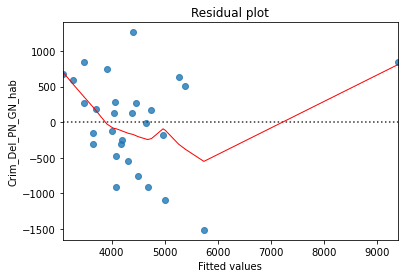

In [51]:


sns.residplot(predictions.reshape(-1),'Crim_Del_PN_GN_hab', data=df_test,lowess=True,
                                  line_kws={'color': 'red', 'lw': 1, 'alpha': 1})
plt.xlabel("Fitted values")
plt.title('Residual plot')

Text(0.5, 1.0, 'Normal Q-Q Plot')

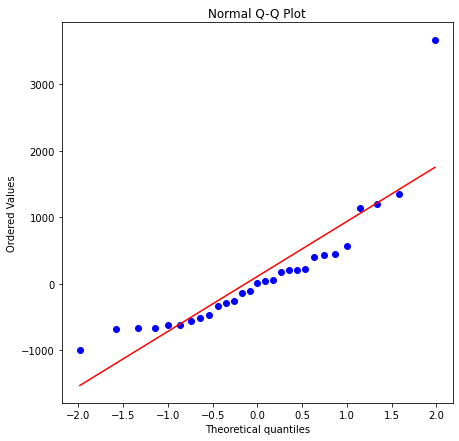

In [52]:
residuals = df_test["Crim_Del_PN_GN_hab"] - predictions.reshape(-1)
residuals

plt.figure(figsize=(7,7))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Normal Q-Q Plot")

/opt/conda/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 0, 'Fitted value')

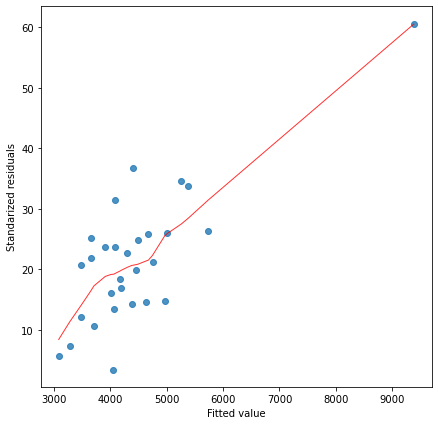

In [53]:
model_norm_residuals_abs_sqrt=np.sqrt(np.abs(residuals))

plt.figure(figsize=(7,7))
sns.regplot(predictions.reshape(-1), model_norm_residuals_abs_sqrt,
              scatter=True,
              lowess=True,
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
plt.ylabel("Standarized residuals")
plt.xlabel("Fitted value")